# Full Analysis

This notebook includes the code for all supervised machine learning tasks performed in the paper. We start by importing the necessary Python libraries.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingRegressor,
    GradientBoostingClassifier,
)
from sklearn.tree import (
    DecisionTreeRegressor,
    DecisionTreeClassifier,
    ExtraTreeRegressor,
    ExtraTreeClassifier,
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR, SVC
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    roc_auc_score,
)
from scipy.stats import randint, uniform, expon, loguniform
from IPython.display import display

# Set global random state params
RNG_SEED = 0
np.random.seed(seed=RNG_SEED)

%matplotlib inline

## Load the Data

The data is loaded from a cleaned CSV file called `parsed_data.csv`. The uncleaned data can be found in the `data` folder, where each system's data is an extensionless text file.

In [2]:
df = pd.read_csv('data/parsed_data.csv')
df

,t,Steps,Event,idx,TFSI,TFSI-flip,EC,EC-flip,Li,Li-flip,...,EC-2-flip,Li-2,Li-2-flip,dx,dy,dz,dr,d,fast,system
0,459.0,306,1,1.0,0.0,78,4.0,50,0.0,0,...,147,0.0,0,-0.02,-1.10,-0.73,1.32,243.13,0.0,B2T1
1,459.0,306,1,2.0,2.0,122,3.0,80,0.0,106,...,164,1.0,110,1.05,-0.61,-0.49,1.31,250.02,0.0,B2T1
2,459.0,306,1,3.0,2.0,99,2.0,104,0.0,8,...,195,1.0,76,-0.27,0.40,0.92,1.04,251.00,0.0,B2T1
3,459.0,306,1,4.0,1.0,125,3.0,6,0.0,0,...,125,0.0,0,0.47,0.05,0.59,0.76,203.19,0.0,B2T1
4,459.0,306,1,5.0,0.0,0,4.0,38,0.0,0,...,162,0.0,16,1.51,1.04,-0.15,1.84,247.00,0.0,B2T1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24895,8721.0,5814,19,96.0,2.0,41,2.0,18,0.0,3,...,60,0.0,50,0.98,-3.90,-1.55,4.31,344.49,1.0,B8T5
24896,8721.0,5814,19,97.0,3.0,164,1.0,9,0.0,0,...,127,1.0,39,-6.13,3.94,-1.87,7.52,347.39,1.0,B8T5
24897,8721.0,5814,19,98.0,2.0,16,2.0,6,0.0,0,...,31,0.0,0,-0.31,0.77,0.09,0.83,335.26,0.0,B8T5
24898,8721.0,5814,19,99.0,0.0,29,4.0,31,0.0,0,...,64,0.0,0,-1.63,1.24,-0.01,2.05,336.03,0.0,B8T5


Only a few of these columns are useful to the task, and they are selected below.

In [3]:
columns = [
    "TFSI",
    "TFSI-flip",
    "EC",
    "EC-flip",
    "Li",
    "Li-flip",
    "TFSI-2",
    "TFSI-2-flip",
    "EC-2",
    "EC-2-flip",
    "Li-2",
    "Li-2-flip",
    "dr",
]

data = df[columns]
data

,TFSI,TFSI-flip,EC,EC-flip,Li,Li-flip,TFSI-2,TFSI-2-flip,EC-2,EC-2-flip,Li-2,Li-2-flip,dr
0,0.0,78,4.0,50,0.0,0,2.0,135,0.0,147,0.0,0,1.32
1,2.0,122,3.0,80,0.0,106,2.0,194,3.0,164,1.0,110,1.31
2,2.0,99,2.0,104,0.0,8,4.0,161,3.0,195,1.0,76,1.04
3,1.0,125,3.0,6,0.0,0,2.0,95,1.0,125,0.0,0,0.76
4,0.0,0,4.0,38,0.0,0,0.0,109,1.0,162,0.0,16,1.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24895,2.0,41,2.0,18,0.0,3,2.0,134,0.0,60,0.0,50,4.31
24896,3.0,164,1.0,9,0.0,0,1.0,184,0.0,127,1.0,39,7.52
24897,2.0,16,2.0,6,0.0,0,2.0,93,0.0,31,0.0,0,0.83
24898,0.0,29,4.0,31,0.0,0,0.0,112,0.0,64,0.0,0,2.05


Machine learning will first be done on the structural features (coordination numbers), then on the structural and dynamic features (changes in coordination numbers). For this reason, it's useful to have a list of columns pertaining to just the coordination numbers and changes/flips in coordination number:

In [4]:
structure = [i for i in data.columns[0:-1] if not i.endswith('flip')]
flips = [i for i in data.columns[0:-1] if i.endswith('flip')]

print(structure)
print(flips)

['TFSI', 'EC', 'Li', 'TFSI-2', 'EC-2', 'Li-2']
['TFSI-flip', 'EC-flip', 'Li-flip', 'TFSI-2-flip', 'EC-2-flip', 'Li-2-flip']


## Helper Functions

Certain tasks are going to be repeated a **bunch**. I've found these helper functions to be super useful across many of my machine learning projects.

For each model, a randomized hyperparameter search cross-validation will be performed using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Randomized search differs from grid search in that a fixed number of parameter samples are tried for each hyperparamter (in a grid search, every combination in a grid is exhaustively searched). For continuous parameters, this makes it easy to provide continuously distributed random variables with simply a lower and upper bound. This project chooses a design budget of 50 iterations for the randomized hyperparamter search (that is, 50 parameter combinations will be randomly sampled and evaluated from the parameter grid). Cross-validation is done by creating holdout/validation sets from the training data during hyperparameter optimization, and the best-performing combination is then re-trained on the full training data once optimization is complete. Because this process will be repeated for each model on every regression task, it's useful to define a helper function for this. The function below has a simple toggle for regression and classification tasks that change the scoring metrics used.

In [5]:
def randomized_search(model, param_dist, X_train, y_train, iters=50, regression=True):
    """
    Performs a RandomizedSearchCV to optimize hyperparameters.
    For the best model, displays the mean and standard deviation of several scoring 
    metrics on the training and holdout (validation) splits for 5-fold cross-validation.

    Args:
        model (sklearn estimator): estimator or pipeline to cross-validate
        param_dist (dict): ranges or distributions of hyperparameters to sample from
        X_train (array-like): training samples for regression
        y_train (array-like): target/label for regression
        iters (int, optional): Number of parameter settings sampled. Defaults to 50.
        regression (bool, optional): Regression (True) or classification (False). Defaults to True.

    Returns:
        RandomizedSearchCV: randomized hyperparameter search CV fitted on training data
    """

    # Get multiple scorers from sklearn.metrics to evaluate during cross-validation
    if regression:
        scoring = {
            "R2": "r2",
            "MAE": "neg_mean_absolute_error",
            "MSE": "neg_mean_squared_error",
            "RMSE": "neg_root_mean_squared_error",
        }
    else:  # classification metrics
        scoring = {
            "Accuracy": "accuracy",
            "Precision": "precision",
            "Recall": "recall",
            "F1 Score": "f1",
            "ROC AUC": "roc_auc",
        }
    # Randomized hyperparamter search cross-validation on estimator and parameter distributions
    random_cv = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=iters,
        scoring=scoring,  # record scores based on all our scoring metrics
        refit="MSE" if regression else "F1 Score",
        cv=5,  # 5-fold cross-validation for each parameter setting sample
        return_train_score=True,  # return scores on training data as well as validation data
        random_state=RNG_SEED,
        n_jobs=-1,  # use all CPU cores
        verbose=10,
    )
    random_cv.fit(X_train, y_train)  # optimize hyperparameters on training data
    results = random_cv.cv_results_  # results of cross-validation
    idx = random_cv.best_index_  # index corresponding to best-performing model

    # For the best model, get the mean and standard deviation of scores on train and val data
    train_means = [abs(results[f"mean_train_{score}"][idx]) for score in scoring.keys()]
    train_std = [results[f"std_train_{score}"][idx] for score in scoring.keys()]
    # By convention, scikit-learn uses "test" to denote holdout/validation splits
    val_means = [abs(results[f"mean_test_{score}"][idx]) for score in scoring.keys()]
    val_std = [results[f"std_test_{score}"][idx] for score in scoring.keys()]

    # Create a DataFrame of the cross-validation scoring summary for the best model
    cross_val_summary = pd.DataFrame(
        data={
            "Mean (Train)": train_means,
            "STD (Train)": train_std,
            "Mean (Val)": val_means,
            "STD (Val)": val_std,
        },
        index=scoring.keys(),
    )
    print("Best hyperparameters:", random_cv.best_params_)
    print("\nMean and standard deviation of performance on 5-fold cross-validation:")
    display(cross_val_summary)  # use IPython display for prettier printing of DataFrame
    return random_cv

Apart from cross-validation results, a scoring summary and a plot plot will be returned for each model for performance on the test set. Helper functions are defined below for both of these tasks. Parity plots are for regressors, while confusion matrices are for classifiers. Note that `score_summary` also has a simple toggle for regression/classification that will change the scoring metrics used. The `plot_pred_act` has a few lines of code that are specific to the scale of the data used in this project (axis ticks and padding of the axes), so those would need to be changed for different projects. I should've made them more generalizable, I know 🙃. Also, I like to develop in Jupyter Notebooks in VS Code, so I've opted to use IPython displays instead of printing for prettier printing of DataFrames containing scoring results. Simply replace those lines with `print()` if using elsewhere.

In [6]:
def score_summary(model, X_train, X_test, y_train, y_test, regression=True):
    """
    Prints scoring metrics of a fitted estimator on training and test data.
    For regression tasks, scores on R2, MAE, MSE, and RMSE.
    For classification tasks, scores on accuracy, precision, recall, F1, and ROC AUC.

    Args:
        model (sklearn estimator): fitted estimator or pipeline
        X_train (array-like): training samples
        X_test (array-like): test/holdout samples
        y_train (array-like): target values for the training set
        y_test (array-like): target values for the test set
        regression (bool, optional): Regression (True) or classification (False). Defaults to True.
    Returns:
        DataFrame: model scores on training and test samples
    """
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    if regression:  # compute scoring metrics for regression
        # train scores
        train_r2 = r2_score(y_train, y_pred_train)
        train_mae = mean_absolute_error(y_train, y_pred_train)
        train_mse = mean_squared_error(y_train, y_pred_train)
        train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
        # test scores
        test_r2 = r2_score(y_test, y_pred)
        test_mae = mean_absolute_error(y_test, y_pred)
        test_mse = mean_squared_error(y_test, y_pred)
        test_rmse = mean_squared_error(y_test, y_pred, squared=False)
        summary = pd.DataFrame(
            data={
                "Training Scores": [train_r2, train_mae, train_mse, train_rmse],
                "Test Scores": [test_r2, test_mae, test_mse, test_rmse],
            },
            index=["R2", "MAE", "MSE", "RMSE"],
        )
    else:  # compute scoring metrics for classification
        # train scores
        train_acc = accuracy_score(y_train, y_pred_train)
        train_rec = recall_score(y_train, y_pred_train)
        train_prec = precision_score(y_train, y_pred_train)
        train_f1 = f1_score(y_train, y_pred_train)
        train_roc = roc_auc_score(y_train, y_pred_train)
        # test scores
        test_acc = accuracy_score(y_test, y_pred)
        test_rec = recall_score(y_test, y_pred)
        test_prec = precision_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred)
        test_roc = roc_auc_score(y_test, y_pred)
        summary = pd.DataFrame(
            data={
                "Training Scores": [train_acc, train_rec, train_prec, train_f1, train_roc],
                "Test Scores": [test_acc, test_rec, test_prec, test_f1, test_roc],
            },
            index=["Accuracy", "Recall", "Precision", "F1 Score", "ROC AUC"],
        )
    print("\nScore summary on full training data and test data:")
    display(summary)
    return summary


def plot_pred_act(
    act, pred, label=r"$\delta r\ (\AA)$", title=False, save=True, save_name="act_pred"
):
    """
    Creates a parity plot for an estimator on testing data

    Args:
        act (array-like): actual values for targets, y_test
        pred (array-like): predicted values for targets
        label (str, optional): name of target y for axes. Defaults to r"$\delta r\ (\AA)$".
        title (str/bool, optional): name of estimator for plot title. Defaults to False.
        save (bool, optional): Whether to save plot image. Defaults to True.
        save_name (str, optional): Filename for saved plot image. Defaults to "act_pred".
    """

    sns.set(style="ticks", font_scale=1.5)
    xy_max = np.max([np.max(act), np.max(pred)])
    xy_min = np.min([np.min(act), np.min(pred)])
    r2 = r2_score(act, pred)
    # make a joint regplot (scatter + linear fit) with histogram/kde of label distributions
    plot = sns.jointplot(
        x=act,
        y=pred,
        kind="reg",
        height=7,
        ratio=4,
        color="#611f53",
        marginal_ticks=True,
        xlim=(xy_min - 0.5, xy_max + 0.5),  # limits with padding (change based on scale of data)
        ylim=(xy_min - 0.5, xy_max + 0.5),
        # scatter plot point kwds
        scatter_kws=dict(s=100, alpha=0.4, edgecolor="k", color="#f6ab83"),
        # fit line kwds
        line_kws=dict(label="linear fit", lw=4),
        # histogram/kde kwds
        marginal_kws=dict(bins=10, kde=True),
    )
    # plot ideal linear fit
    plot.ax_joint.plot([xy_min, xy_max], [xy_min, xy_max], "k--", label="ideal")
    # set title, axes labels, make legend, and show plot
    plot.set_axis_labels(f"Actual {label}", f"Predicted {label}")
    plot.ax_joint.set_xticks(np.linspace(0, 14, 8))  # keep x-axis ticks consistent
    if title:  # truth value of a str is True, False otherwise
        plot.fig.suptitle(fr"{title}: $R^2$ = {r2:.4f}")
    plot.fig.tight_layout()
    plot.ax_joint.legend()
    if save:
        plt.savefig(f"figures/{save_name}.png", dpi=300, bbox_inches="tight")
    plt.show()


def plot_confusion_matrix(model, X_test, y_test, save=True, name="classification"):
    """
    Creates a confusion matrix on the test data

    Args:
        model (sklearn estimator): estimator or pipeline for classification
        X_test (array-like): test samples
        y_test (array-like): ground truths for test set
        save (bool, optional): Whether to save an image of the plot. Defaults to True.
        name (str, optional): Filename for the saved image. Defaults to "classification".
    """
    f1 = f1_score(y_test, model.predict(X_test))
    sns.set(font_scale=2)
    plt.figure(figsize=(10, 8))
    conf_matrix = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(
        conf_matrix,
        annot=True,
        xticklabels=["slow", "fast"],
        yticklabels=["slow", "fast"],
        cbar=True,
        cmap="flare",
        fmt="g",
        linewidths=3,
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.yticks(rotation=0)
    plt.title(f"Classification F1: {f1:.4f}")
    if save:
        plt.savefig(f"figures/{name}.png", dpi=500, bbox_inches="tight")
    plt.show()

## Coordination Numbers as the Only Features

Machine learning was first done using only "structural features," i.e. coordination numbers alone. Here, the data is selected and split using only the structural features.

In [7]:
X = data[structure]
y = data["dr"]

# create training and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RNG_SEED
)
struct_results = {}  # created for the sake of organizing results for my thesis

Machine learning analysis will be done using the following models, both for regression and classification:
- [Dummy model](https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators)
- [Ridge](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) using 2nd-order polynomial features
- [K-Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html#classification)
- [Decision Trees](https://scikit-learn.org/stable/modules/tree.html)
- [Extra Trees](https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees)
- [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html)
- [Random Forests](https://scikit-learn.org/stable/modules/ensemble.html#random-forests)
- [Gradient Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)

A scikit-learn [`PipeLine`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) was used for each model. When you have a sequence of transformations that you always perform on your data, it's best practice to use pipelines to keep all this in check. All but the last estimator in a pipeline must be a transformer (have a `transform()` method). Calling `fit()` on a pipeline will call `fit_transform()` on all but the last step (usually the instantiated model), for which it applies `fit()`. This allows you to seamlessly preprocess data and fit a model without ever skipping a step.

[`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) was found to have the best performance for this design project, but others such as [`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) and [`PowerTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) led to similar results. For a comparison on how these affect the scale and distributions of your data, see [this guide from scikit-learn](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#original-data). I found that [normalization](https://scikit-learn.org/stable/modules/preprocessing.html#normalization) was unnecessary for this project. It led to no performance increase and just made all the models take longer to train.

### Regression

#### Dummy

The dummy regressor acts as a baseline, and it simply predicts the mean of the target.


Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.000000,-0.000969
MAE,1.415430,1.381654
MSE,3.294930,3.131351
RMSE,1.815194,1.769562


C:\Users\khanm\anaconda3\envs\mse7050\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


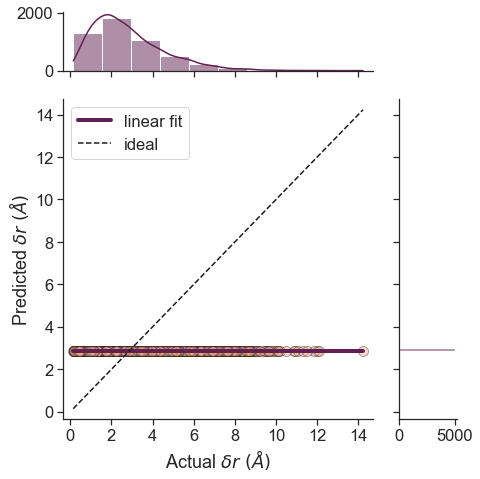

In [8]:
dummy = Pipeline([
    ("scaler", StandardScaler()),
    ("model", DummyRegressor())
])
dummy.fit(X_train, y_train)

struct_results["dummy"] = score_summary(dummy, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, dummy.predict(X_test), save_name="struct_actpred_dummy")

#### Linear (Polynomial Ridge)

Why [polynomial features](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) for the Ridge regressor? It's highly unlikely that the correlations between the features and the target are strictly linear (as was seen in the correlation heatmap during exploratory data analysis 😉). Moreover, second-order polynomials allow synergistic effects to be explored between features. Polynomial features are only used for this linear model, since all the other models are able to learn at least some sort of nonlinear relations. Note here that we create polynomial features, then scale, then use our model.

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__alpha': 1.6598654663071277}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.014724,0.001163,0.011330,0.004842
MAE,1.401687,0.004476,1.404144,0.016822
MSE,3.246330,0.019848,3.256197,0.079020
RMSE,1.801749,0.005504,1.804360,0.021956



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.014453,0.006969
MAE,1.401934,1.375519
MSE,3.247309,3.106518
RMSE,1.802029,1.762532


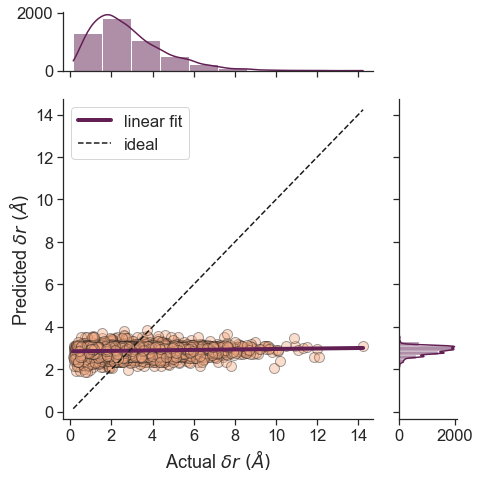

In [9]:
# create polynomial features, scale/normalize features, then instantiate model
linear = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)),
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

# set up distributions of hyperparameters for optimization
linear_params = {"model__alpha": loguniform(1E-5, 10)}

# perform a randomized hyperparameter search and print out CV scoring metrics
linear_random_cv = randomized_search(linear, linear_params, X_train, y_train)
best_linear = linear_random_cv.best_estimator_

# print out a score summary on full training set and test set
struct_results["ridge"] = score_summary(best_linear, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_linear.predict(X_test), save_name="struct_ridge")

#### Nearest Neighbors Regression

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__leaf_size': 18, 'model__n_neighbors': 14, 'model__weights': 'uniform'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.013781,0.002536,0.061307,0.017908
MAE,1.416256,0.011686,1.447825,0.016304
MSE,3.340284,0.026234,3.494344,0.053712
RMSE,1.827630,0.007182,1.869261,0.014353



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,-0.019129,-0.079234
MAE,1.418923,1.431201
MSE,3.357958,3.376188
RMSE,1.832473,1.837441


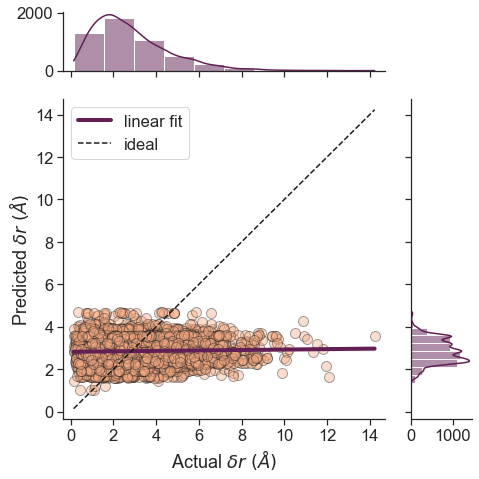

In [10]:
# set up a pipeline to scale/normalize features, then instantiate model
knr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsRegressor())
])

# create distributions of hyperparameters to explore
knr_params = {
    "model__n_neighbors": randint(5, 15),
    "model__weights": ["uniform", "distance"],
    "model__leaf_size": randint(10, 60),
}

# perform a randomized hyperparameter search and print out CV scoring metrics
knr_random_cv = randomized_search(knr, knr_params, X_train, y_train)
best_knr = knr_random_cv.best_estimator_

# print out a score summary on full training set and test set
struct_results["knn"] = score_summary(best_knr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_knr.predict(X_test), save_name="struct_knn")

#### Decision Trees

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__max_depth': 42, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 9, 'model__min_samples_split': 4, 'model__splitter': 'random'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.015935,0.002578,0.003708,0.003913
MAE,1.401164,0.004763,1.410481,0.014846
MSE,3.242321,0.017914,3.281098,0.070398
RMSE,1.800638,0.004974,1.811276,0.019468



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.021084,0.003633
MAE,1.396801,1.376459
MSE,3.225458,3.116953
RMSE,1.795956,1.765489


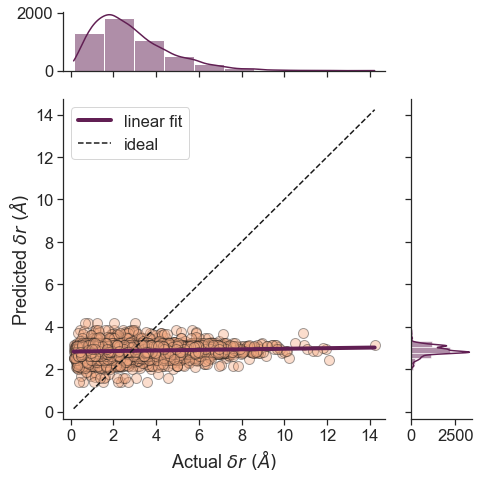

In [11]:
# set up a pipeline to scale/normalize features, then instantiate model
dtr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", DecisionTreeRegressor(random_state=RNG_SEED))
])

# create distributions of hyperparameters to explore
dtr_params = {
    "model__splitter": ['best', 'random'],
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__max_depth": randint(5, 100),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
}

# perform a randomized hyperparameter search and print out CV scoring metrics
dtr_random_cv = randomized_search(dtr, dtr_params, X_train, y_train)
best_dtr = dtr_random_cv.best_estimator_

# print out a score summary on full training set and test set
struct_results["dtr"] = score_summary(best_dtr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_dtr.predict(X_test), save_name="struct_dtr")

#### Extra Trees Regression

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__max_depth': 92, 'model__max_features': 'log2', 'model__min_samples_leaf': 9, 'model__min_samples_split': 14}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.015935,0.002578,0.003708,0.003913
MAE,1.401164,0.004763,1.410481,0.014846
MSE,3.242321,0.017914,3.281098,0.070398
RMSE,1.800638,0.004974,1.811276,0.019468



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.021084,0.003633
MAE,1.396801,1.376459
MSE,3.225458,3.116953
RMSE,1.795956,1.765489


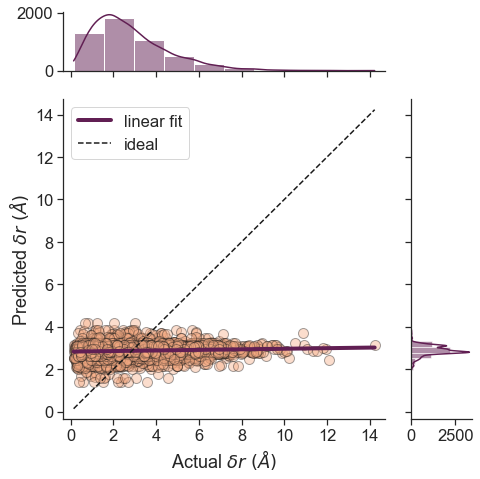

In [12]:
# set up a pipeline to scale/normalize features, then instantiate model
etr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ExtraTreeRegressor(random_state=RNG_SEED))
])

# create distributions of hyperparameters to explore
etr_params = {
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__max_depth": randint(5, 100),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
}

# perform a randomized hyperparameter search and print out CV scoring metrics
etr_random_cv = randomized_search(etr, etr_params, X_train, y_train)
best_etr = etr_random_cv.best_estimator_

# print out a score summary on full training set and test set
struct_results["etr"] = score_summary(best_etr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_etr.predict(X_test), save_name="struct_etr")

#### Support Vector Machines

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'model__C': 2, 'model__epsilon': 0.4166900152330658}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.015024,0.001992,0.033773,0.009456
MAE,1.352351,0.004131,1.371028,0.015544
MSE,3.344353,0.022086,3.405069,0.097898
RMSE,1.828747,0.006035,1.845089,0.026729



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,-0.016186,-0.024943
MAE,1.354020,1.331359
MSE,3.348262,3.206348
RMSE,1.829826,1.790628


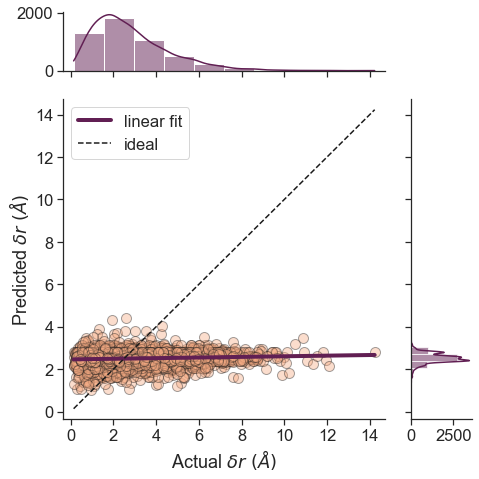

In [13]:
svr = Pipeline([("scaler", StandardScaler()), ("model", SVR(kernel="rbf"))])

svr_params = {"model__C": randint(1, 50), "model__epsilon": uniform(0.1, 0.4)}

svr_random_cv = randomized_search(svr, svr_params, X_train, y_train, iters=20)
best_svr = svr_random_cv.best_estimator_

struct_results["svr"] = score_summary(best_svr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_svr.predict(X_test), save_name="struct_svr")

#### Random Forests

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__bootstrap': False, 'model__max_depth': 8, 'model__max_features': 'log2', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 224}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.026383,0.001498,0.009982,0.004164
MAE,1.393962,0.004468,1.405747,0.015996
MSE,3.207910,0.018622,3.260520,0.073784
RMSE,1.791056,0.005195,1.805575,0.020476



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.025128,0.006938
MAE,1.394942,1.374103
MSE,3.212135,3.106614
RMSE,1.792243,1.762559


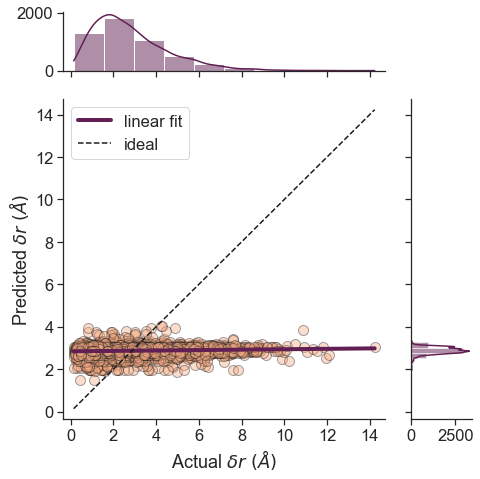

In [14]:
rfr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(random_state=RNG_SEED))
])

rfr_params = {
    "model__n_estimators": randint(10, 500),
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__max_depth": randint(5, 100),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__bootstrap": [True, False],
}

rf_random_cv = randomized_search(rfr, rfr_params, X_train, y_train)
best_rfr = rf_random_cv.best_estimator_

struct_results["rfr"] = score_summary(best_rfr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_rfr.predict(X_test), save_name="struct_rfr")

#### Gradient Boosting

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__learning_rate': 0.44513474834717914, 'model__max_depth': 4, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 8, 'model__n_estimators': 301, 'model__warm_start': True}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.055452,0.002020,0.010669,0.010067
MAE,1.366303,0.004757,1.415868,0.016951
MSE,3.112122,0.016678,3.328276,0.069718
RMSE,1.764114,0.004723,1.824255,0.019182



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.049577,-0.017369
MAE,1.371584,1.386724
MSE,3.131578,3.182653
RMSE,1.769627,1.783999


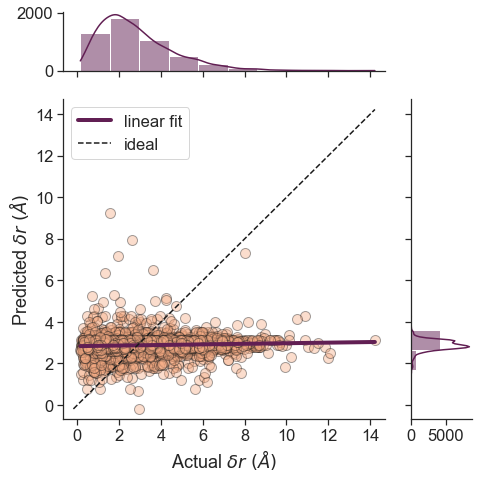

In [15]:
gbr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", GradientBoostingRegressor(random_state=RNG_SEED))
])

gbr_params = {
    "model__n_estimators": randint(10, 500),
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__max_depth": randint(1, 100),
    "model__learning_rate": uniform(0.1, 0.8),
    "model__min_samples_split": randint(2, 11),
    "model__min_samples_leaf": randint(1, 5),
    "model__warm_start": [True, False],
}

gbr_random_cv = randomized_search(gbr, gbr_params, X_train, y_train)
best_gbr = gbr_random_cv.best_estimator_

struct_results["gbr"] = score_summary(best_gbr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_gbr.predict(X_test), save_name="struct_gbr")

#### Summary

In [16]:
def get_summary_df(results_dict, index_names):
    keys = results_dict.keys()
    results = []
    for key, name in zip(keys, index_names):
        results.append(results_dict[key]["Test Scores"].rename(name))
    summary = pd.concat(results, axis="columns").T
    display(summary)
    return summary


names = [
    "Dummy",
    "Polynomial Ridge",
    "KNN",
    "Decision Tree",
    "Extra Trees",
    "SVM",
    "Random Forest",
    "Gradient Boosting",
]
reg_results_struct = get_summary_df(struct_results, names)
reg_results_struct.to_csv("tables/reg_results_struct.csv")

,R2,MAE,MSE,RMSE
Dummy,-0.000969,1.381654,3.131351,1.769562
Polynomial Ridge,0.006969,1.375519,3.106518,1.762532
KNN,-0.079234,1.431201,3.376188,1.837441
Decision Tree,0.003633,1.376459,3.116953,1.765489
Extra Trees,0.003633,1.376459,3.116953,1.765489
SVM,-0.024943,1.331359,3.206348,1.790628
Random Forest,0.006938,1.374103,3.106614,1.762559
Gradient Boosting,-0.017369,1.386724,3.182653,1.783999


Regression performance is pretty terrible using just structural features. Many models are outperformed by the dummy models, with polynomial ridge just slightly better than the others. All models tend to predict displacement values near $3.0 \AA$ only, which really isn't far removed from what a dummy regressor is doing.

### Classification

In [17]:
X = data[structure]
y = df["fast"]

# create training and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RNG_SEED
)
struct_class_results = {}

#### Dummy


Score summary on full training data and test data:


C:\Users\khanm\anaconda3\envs\mse7050\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\khanm\anaconda3\envs\mse7050\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Training Scores,Test Scores
Accuracy,0.615562,0.63012
Recall,0.000000,0.00000
Precision,0.000000,0.00000
F1 Score,0.000000,0.00000
ROC AUC,0.500000,0.50000


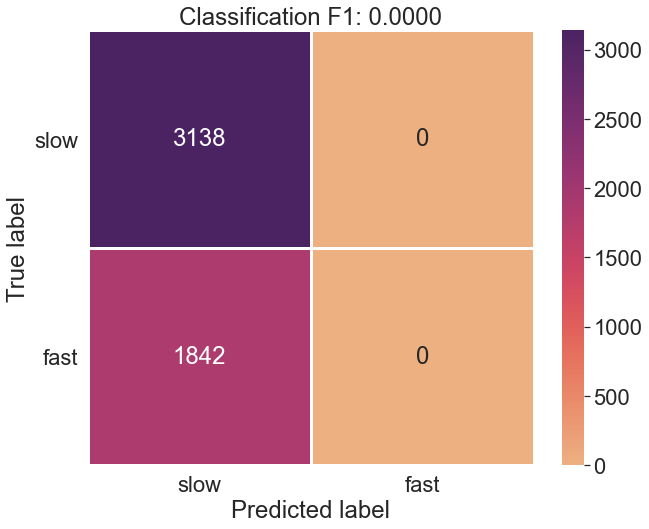

In [18]:
dummy_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", DummyClassifier())
])
dummy_clf.fit(X_train, y_train)
struct_class_results["dummy"] = score_summary(dummy_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(dummy_clf, X_test, y_test, name="struct_class_dummy")

#### Ridge

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__alpha': 2.2420123713724416}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.616391,0.000415,0.615161,0.000699
Precision,0.582032,0.035448,0.478120,0.068503
Recall,0.007672,0.002892,0.006399,0.002241
F1 Score,0.015115,0.005654,0.012599,0.004349
ROC AUC,0.559793,0.003143,0.553311,0.012234



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.616516,0.629518
Recall,0.005746,0.002714
Precision,0.637681,0.384615
F1 Score,0.011389,0.005391
ROC AUC,0.501853,0.500083


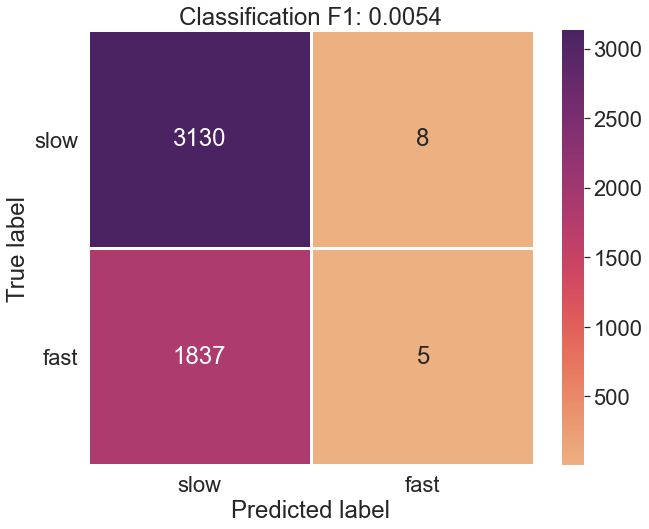

In [19]:
# create polynomial features, scale/normalize features, then instantiate model
ridge_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)),
    ("scaler", StandardScaler()),
    ("model", RidgeClassifier(random_state=RNG_SEED))
])

# set up distributions of hyperparameters for optimization
ridge_clf_params = {"model__alpha": loguniform(1E-5, 10)}

# perform a randomized hyperparameter search and print out CV scoring metrics
ridge_clf_random_cv = randomized_search(ridge_clf, ridge_clf_params, X_train, y_train, regression=False)
best_ridge_clf = ridge_clf_random_cv.best_estimator_

# print out a score summary on full training set and test set
struct_class_results["ridge"] = score_summary(best_ridge_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_ridge_clf, X_test, y_test, name="struct_class_ridge")

#### KNN

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__leaf_size': 38, 'model__n_neighbors': 3, 'model__weights': 'uniform'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.583070,0.011389,0.554016,0.009629
Precision,0.445754,0.012168,0.392747,0.005487
Recall,0.332853,0.056157,0.294598,0.050631
F1 Score,0.377394,0.037229,0.334165,0.037462
ROC AUC,0.549890,0.004002,0.508303,0.004845



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.574147,0.550201
Recall,0.336250,0.282845
Precision,0.430962,0.361806
F1 Score,0.377760,0.317489
ROC AUC,0.529485,0.494992


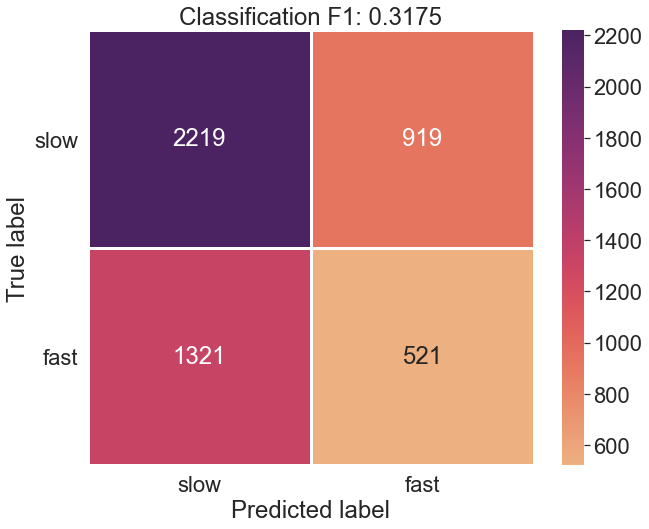

In [20]:
knn_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier())
])

knn_clf_params = {
    "model__n_neighbors": randint(1, 15),
    "model__weights": ["uniform", "distance"],
    "model__leaf_size": randint(10, 60),
}

knn_clf_random_cv = randomized_search(knn_clf, knn_clf_params, X_train, y_train, regression=False)
best_knn_clf =  knn_clf_random_cv.best_estimator_
struct_class_results["knn"] = score_summary(best_knn_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_knn_clf, X_test, y_test, name="struct_class_knn")

#### Decision Trees

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__criterion': 'gini', 'model__max_depth': 57, 'model__max_features': 'auto', 'model__min_samples_leaf': 1, 'model__min_samples_split': 6, 'model__splitter': 'random'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.633672,0.000585,0.603514,0.003089
Precision,0.644984,0.013858,0.408630,0.020811
Recall,0.105575,0.009232,0.069471,0.005016
F1 Score,0.181197,0.013083,0.118666,0.007596
ROC AUC,0.620299,0.002081,0.536508,0.009903



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.631627,0.619277
Recall,0.093236,0.052660
Precision,0.644404,0.391129
F1 Score,0.162902,0.092823
ROC AUC,0.530552,0.502270


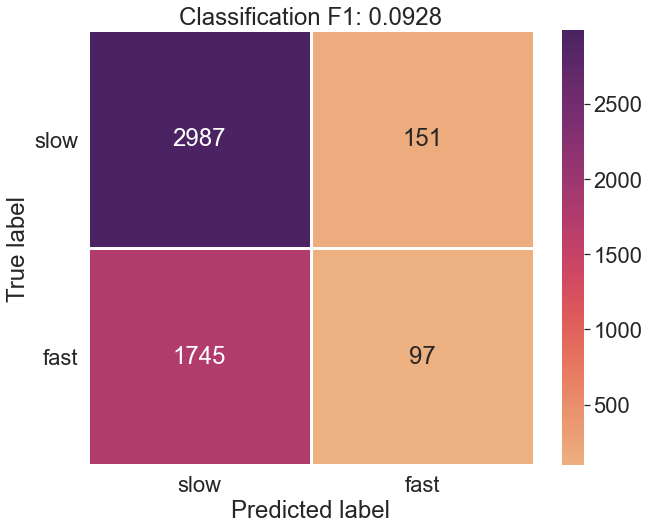

In [21]:
# set up a pipeline to scale/normalize features, then instantiate model
dt_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", DecisionTreeClassifier(random_state=RNG_SEED))
])

# create distributions of hyperparameters to explore
dt_clf_params = {
    "model__criterion": ["gini", "entropy"],
    "model__splitter": ['best', 'random'],
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__max_depth": randint(5, 100),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
}

# perform a randomized hyperparameter search and print out CV scoring metrics
dt_clf_random_cv = randomized_search(dt_clf, dt_clf_params, X_train, y_train, regression=False)
best_dt_clf = dt_clf_random_cv.best_estimator_

# print out a score summary on full training set and test set
struct_class_results["dt"] = score_summary(best_dt_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_dt_clf, X_test, y_test, name="struct_class_dt")

#### Extra Trees

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__criterion': 'gini', 'model__max_depth': 57, 'model__max_features': 'auto', 'model__min_samples_leaf': 1, 'model__min_samples_split': 6, 'model__splitter': 'random'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.633672,0.000585,0.603514,0.003089
Precision,0.644984,0.013858,0.408630,0.020811
Recall,0.105575,0.009232,0.069471,0.005016
F1 Score,0.181197,0.013083,0.118666,0.007596
ROC AUC,0.620299,0.002081,0.536508,0.009903



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.631627,0.619277
Recall,0.093236,0.052660
Precision,0.644404,0.391129
F1 Score,0.162902,0.092823
ROC AUC,0.530552,0.502270


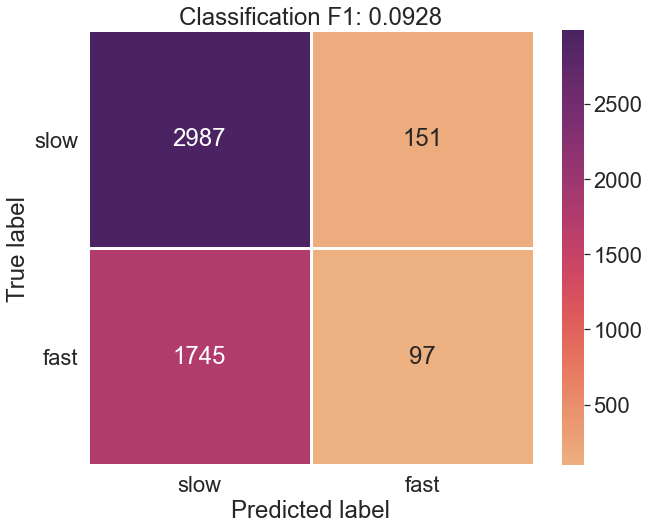

In [22]:
# set up a pipeline to scale/normalize features, then instantiate model
et_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ExtraTreeClassifier(random_state=RNG_SEED))
])

# create distributions of hyperparameters to explore
et_clf_params = {
    "model__criterion": ["gini", "entropy"],
    "model__splitter": ['best', 'random'],
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__max_depth": randint(5, 100),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
}

# perform a randomized hyperparameter search and print out CV scoring metrics
et_clf_random_cv = randomized_search(et_clf, et_clf_params, X_train, y_train, regression=False)
best_et_clf = et_clf_random_cv.best_estimator_

# print out a score summary on full training set and test set
struct_class_results["et"] = score_summary(best_et_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_et_clf, X_test, y_test, name="struct_class_et")

#### SVM

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'model__C': 20.273255210020587, 'model__gamma': 0.9672042018045066}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.637613,0.000717,0.599347,0.003165
Precision,0.651537,0.014317,0.394099,0.019108
Recall,0.124086,0.009039,0.078612,0.007618
F1 Score,0.208227,0.012127,0.130972,0.011216
ROC AUC,0.551321,0.006939,0.505823,0.006208



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.634337,0.617068
Recall,0.106033,0.060803
Precision,0.649600,0.387543
F1 Score,0.182308,0.105115
ROC AUC,0.535156,0.502199


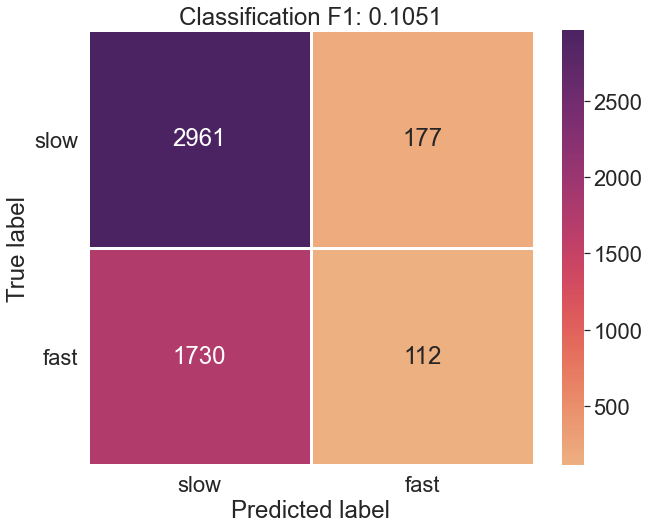

In [23]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(kernel="rbf", random_state=RNG_SEED)),
])

svm_clf_params = {
    "model__C": uniform(1, 20),
    "model__gamma": expon(scale=2)
}

svm_clf_random_cv = randomized_search(svm_clf, svm_clf_params, X_train, y_train, iters=20, regression=False)
best_svm_clf = svm_clf_random_cv.best_estimator_
struct_class_results["svm"] = score_summary(best_svm_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_svm_clf, X_test, y_test, name="struct_class_svm")

#### Random Forests

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__bootstrap': True, 'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 7, 'model__n_estimators': 392}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.525264,0.008181,0.514458,0.007264
Precision,0.419277,0.003603,0.408663,0.008091
Recall,0.608481,0.024106,0.589969,0.033796
F1 Score,0.496184,0.005736,0.482634,0.016202
ROC AUC,0.565222,0.002390,0.545268,0.015185



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.516817,0.499598
Recall,0.635022,0.623779
Precision,0.415890,0.389756
F1 Score,0.502610,0.479749
ROC AUC,0.539008,0.525242


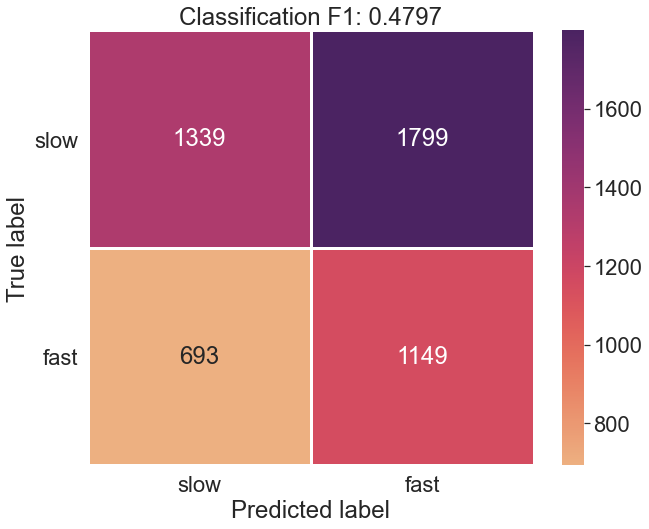

In [24]:
rf_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(random_state=RNG_SEED))
])

rf_clf_params = {
    "model__n_estimators": randint(10, 500),
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": randint(5, 100),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__bootstrap": [True, False],
    "model__class_weight": ['balanced', 'balanced_subsample']
}

rf_clf_random_cv = randomized_search(rf_clf, rf_clf_params, X_train, y_train, regression=False)
best_rf_clf =  rf_clf_random_cv.best_estimator_
struct_class_results["rf"] = score_summary(best_rf_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_rf_clf, X_test, y_test, name="struct_class_rf")

#### Gradient Boosting

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__learning_rate': 0.7226763856207272, 'model__loss': 'exponential', 'model__max_depth': 65, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 379, 'model__warm_start': True}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.637676,0.000708,0.598645,0.002618
Precision,0.643818,0.013095,0.396996,0.010692
Recall,0.129603,0.010443,0.084488,0.006598
F1 Score,0.215474,0.013761,0.139184,0.008997
ROC AUC,0.628902,0.002160,0.535470,0.009408



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.634388,0.616667
Recall,0.110473,0.064604
Precision,0.642369,0.390164
F1 Score,0.188524,0.110852
ROC AUC,0.536031,0.502665


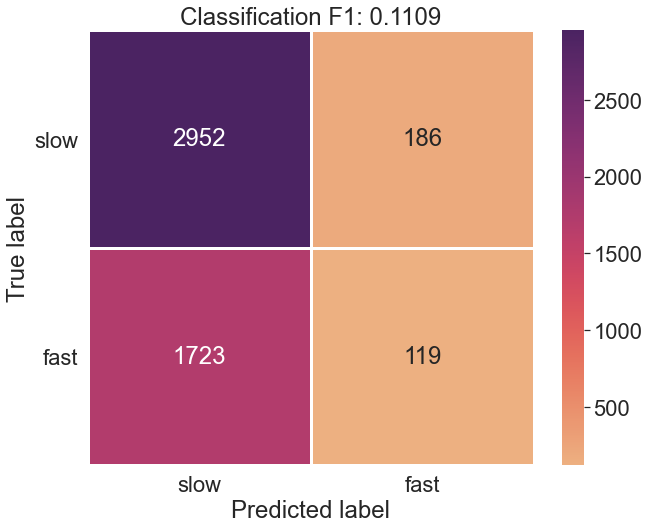

In [25]:
gb_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", GradientBoostingClassifier(random_state=RNG_SEED))
])

gb_clf_params = {
    "model__n_estimators": randint(10, 500),
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__loss": ["deviance", "exponential"],
    "model__max_depth": randint(1, 100),
    "model__learning_rate": uniform(0.1, 0.8),
    "model__min_samples_split": randint(2, 11),
    "model__min_samples_leaf": randint(1, 5),
    "model__warm_start": [True, False],
}

gb_clf_random_cv = randomized_search(gb_clf, gb_clf_params, X_train, y_train, regression=False)
best_gb_clf =  gb_clf_random_cv.best_estimator_
struct_class_results["gb"] = score_summary(best_gb_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_gb_clf, X_test, y_test, name="struct_class_gb")

#### Summary

In [26]:
clf_results_struct = get_summary_df(struct_class_results, names)
clf_results_struct.to_csv("tables/clf_results_struct.csv")

,Accuracy,Recall,Precision,F1 Score,ROC AUC
Dummy,0.630120,0.000000,0.000000,0.000000,0.500000
Polynomial Ridge,0.629518,0.002714,0.384615,0.005391,0.500083
KNN,0.550201,0.282845,0.361806,0.317489,0.494992
Decision Tree,0.619277,0.052660,0.391129,0.092823,0.502270
Extra Trees,0.619277,0.052660,0.391129,0.092823,0.502270
SVM,0.617068,0.060803,0.387543,0.105115,0.502199
Random Forest,0.499598,0.623779,0.389756,0.479749,0.525242
Gradient Boosting,0.616667,0.064604,0.390164,0.110852,0.502665


## Coordination Numbers and Changes in Coordination as Features

In [27]:
X = data[structure + flips]
y = data['dr']

# create training and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RNG_SEED
)
results = {}

### Regression
#### Dummy


Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.000000,-0.000969
MAE,1.415430,1.381654
MSE,3.294930,3.131351
RMSE,1.815194,1.769562


C:\Users\khanm\anaconda3\envs\mse7050\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


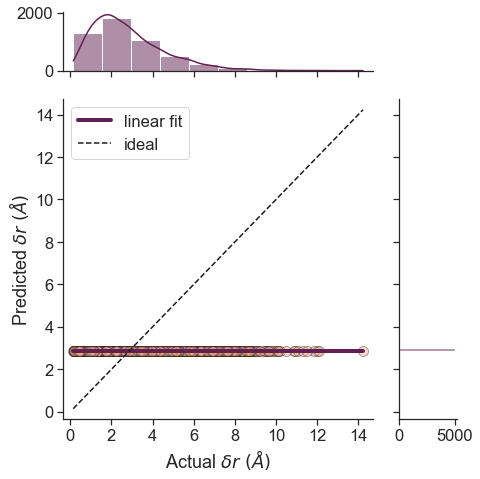

In [28]:
dummy.fit(X_train, y_train)

results["dummy"] = score_summary(dummy, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, dummy.predict(X_test), save_name="actpred_dummy")

#### Ridge

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__alpha': 4.656005689076002}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.150740,0.001255,0.143545,0.005684
MAE,1.286756,0.003319,1.292417,0.014434
MSE,2.798165,0.014624,2.820486,0.058444
RMSE,1.672766,0.004370,1.679340,0.017415



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.150102,0.137568
MAE,1.287315,1.273335
MSE,2.800354,2.697960
RMSE,1.673426,1.642547


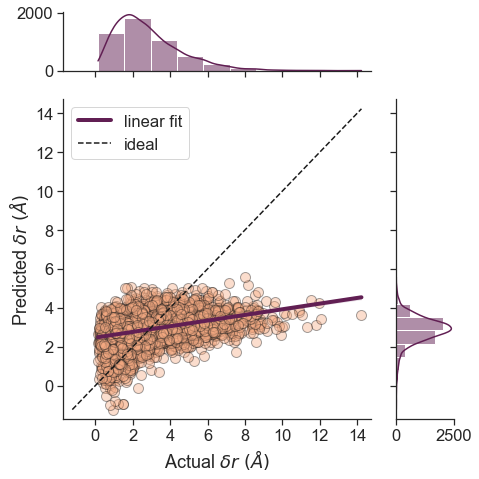

In [29]:
linear_random_cv = randomized_search(linear, linear_params, X_train, y_train)
best_linear = linear_random_cv.best_estimator_
results["ridge"] = score_summary(best_linear, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_linear.predict(X_test), save_name="actpred_ridge")

#### KNN

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__leaf_size': 18, 'model__n_neighbors': 14, 'model__weights': 'uniform'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.192243,0.002322,0.070365,0.012508
MAE,1.269319,0.004273,1.363430,0.017070
MSE,2.661413,0.014309,3.061257,0.062504
RMSE,1.631378,0.004385,1.749553,0.017887



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.196156,0.056332
MAE,1.264936,1.344073
MSE,2.648611,2.952093
RMSE,1.627455,1.718166


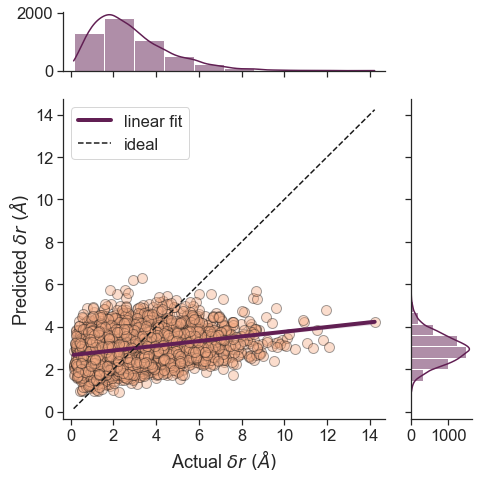

In [30]:
knr_random_cv = randomized_search(knr, knr_params, X_train, y_train)
best_knr = knr_random_cv.best_estimator_
results["knn"] = score_summary(best_knr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_knr.predict(X_test), save_name="actpred_knn")

#### Decision Trees

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__max_depth': 5, 'model__max_features': 'auto', 'model__min_samples_leaf': 6, 'model__min_samples_split': 7, 'model__splitter': 'best'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.101137,0.002391,0.081827,0.005979
MAE,1.327394,0.004338,1.343384,0.014673
MSE,2.961621,0.020383,3.023765,0.063833
RMSE,1.720926,0.005920,1.738801,0.018370



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.098075,0.077068
MAE,1.330596,1.320594
MSE,2.971781,2.887224
RMSE,1.723885,1.699183


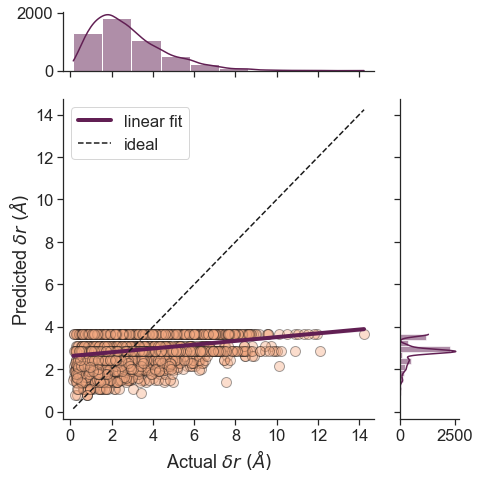

In [31]:
dtr_random_cv = randomized_search(dtr, dtr_params, X_train, y_train)
best_dtr = dtr_random_cv.best_estimator_
results["dtr"] = score_summary(best_dtr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_dtr.predict(X_test), save_name="actpred_dtr")

#### Extra Trees

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__max_depth': 8, 'model__max_features': 'auto', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.113186,0.003894,0.077207,0.017136
MAE,1.315945,0.006107,1.345992,0.020825
MSE,2.921984,0.029560,3.038487,0.062365
RMSE,1.709359,0.008643,1.743033,0.017934



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.118346,0.084945
MAE,1.312411,1.311801
MSE,2.904989,2.862583
RMSE,1.704403,1.691917


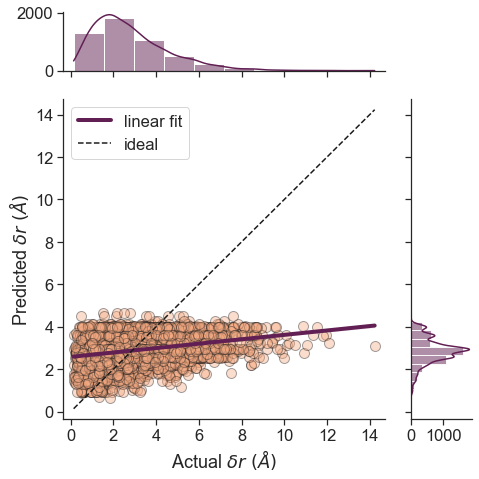

In [32]:
etr_random_cv = randomized_search(etr, etr_params, X_train, y_train)
best_etr = etr_random_cv.best_estimator_
results["etr"] = score_summary(best_etr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_etr.predict(X_test), save_name="actpred_etr")

#### SVM

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'model__C': 2, 'model__epsilon': 0.4166900152330658}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.182001,0.001819,0.131396,0.004117
MAE,1.194278,0.003328,1.248461,0.013621
MSE,2.695177,0.016984,2.860758,0.069220
RMSE,1.641691,0.005174,1.691253,0.020533



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.179680,0.129127
MAE,1.197364,1.234463
MSE,2.702897,2.724367
RMSE,1.644049,1.650566


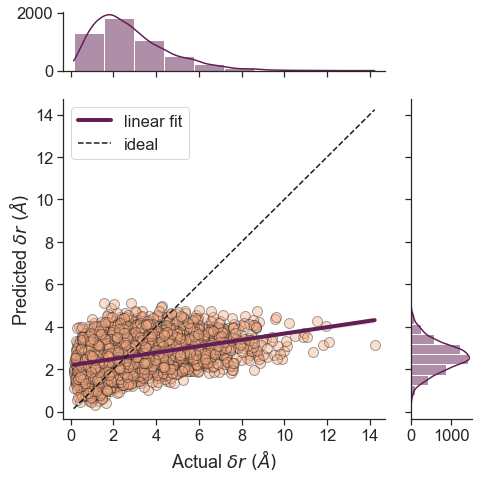

In [33]:
svr_random_cv = randomized_search(svr, svr_params, X_train, y_train, iters=20)
best_svr = svr_random_cv.best_estimator_
results["svr"] = score_summary(best_svr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_svr.predict(X_test), save_name="actpred_svr")

#### Random Forests

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__bootstrap': True, 'model__max_depth': 65, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 370}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.406378,0.001392,0.145684,0.007184
MAE,1.066532,0.002596,1.287140,0.015584
MSE,1.955881,0.010595,2.813585,0.066419
RMSE,1.398523,0.003787,1.677257,0.019801



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.406748,0.141026
MAE,1.065429,1.266903
MSE,1.954723,2.687144
RMSE,1.398114,1.639251


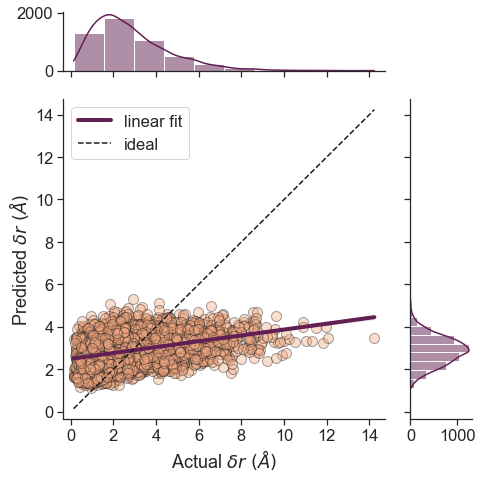

In [34]:
rf_random_cv = randomized_search(rfr, rfr_params, X_train, y_train)
best_rfr = rf_random_cv.best_estimator_
results["rfr"] = score_summary(best_rfr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_rfr.predict(X_test), save_name="actpred_rfr")

#### Gradient Boosting

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__learning_rate': 0.44513474834717914, 'model__max_depth': 4, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 8, 'model__n_estimators': 301, 'model__warm_start': True}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.428037,0.002443,0.089126,0.018823
MAE,1.033977,0.001617,1.326962,0.014303
MSE,1.884488,0.005810,2.999089,0.060351
RMSE,1.372765,0.002116,1.731699,0.017494



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.389444,0.075006
MAE,1.070789,1.305429
MSE,2.011739,2.893676
RMSE,1.418358,1.701081


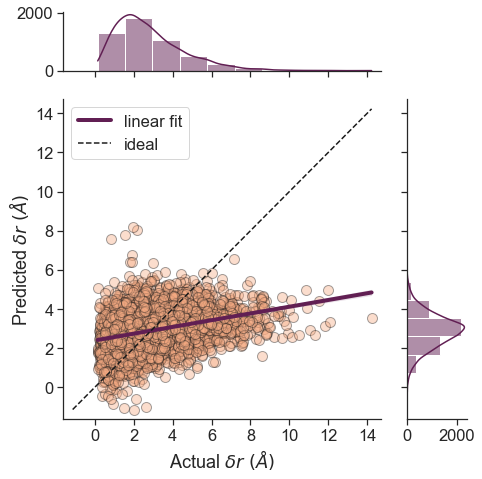

In [35]:
gbr_random_cv = randomized_search(gbr, gbr_params, X_train, y_train)
best_gbr = gbr_random_cv.best_estimator_
results["gbr"] = score_summary(best_gbr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_gbr.predict(X_test), save_name="actpred_gbr")

#### Summary

In [36]:
reg_results = get_summary_df(results, names)
reg_results.to_csv("tables/reg_results.csv")

,R2,MAE,MSE,RMSE
Dummy,-0.000969,1.381654,3.131351,1.769562
Polynomial Ridge,0.137568,1.273335,2.697960,1.642547
KNN,0.056332,1.344073,2.952093,1.718166
Decision Tree,0.077068,1.320594,2.887224,1.699183
Extra Trees,0.084945,1.311801,2.862583,1.691917
SVM,0.129127,1.234463,2.724367,1.650566
Random Forest,0.141026,1.266903,2.687144,1.639251
Gradient Boosting,0.075006,1.305429,2.893676,1.701081


### Classification

In [37]:
X = data[structure + flips]
y = df["fast"]

# create training and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RNG_SEED
)
class_results = {}

#### Dummy


Score summary on full training data and test data:


C:\Users\khanm\anaconda3\envs\mse7050\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\khanm\anaconda3\envs\mse7050\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Training Scores,Test Scores
Accuracy,0.615562,0.63012
Recall,0.000000,0.00000
Precision,0.000000,0.00000
F1 Score,0.000000,0.00000
ROC AUC,0.500000,0.50000


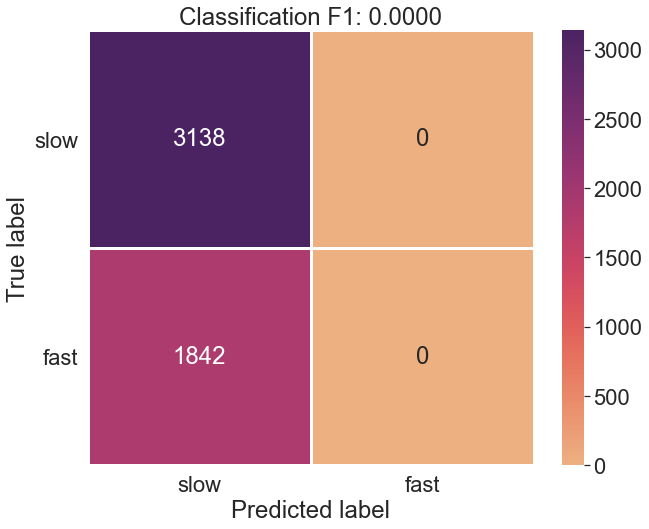

In [38]:
dummy_clf.fit(X_train, y_train)
class_results["dummy"] = score_summary(dummy_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(dummy_clf, X_test, y_test, name="class_dummy")

#### Ridge

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__alpha': 0.0196282248134428}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.657593,0.000737,0.652811,0.005473
Precision,0.602187,0.002315,0.591581,0.016124
Recall,0.322212,0.005220,0.314311,0.006708
F1 Score,0.419769,0.004200,0.410391,0.006504
ROC AUC,0.696259,0.001550,0.688560,0.007656



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.656526,0.658032
Recall,0.319796,0.313246
Precision,0.599951,0.568473
F1 Score,0.417206,0.403920
ROC AUC,0.593310,0.586834


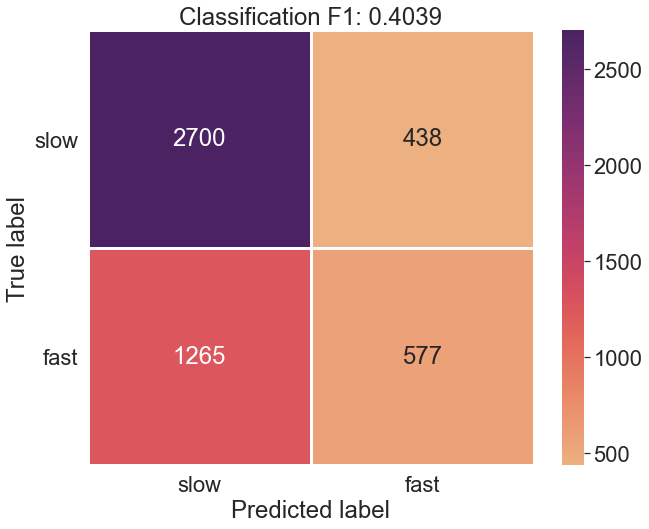

In [39]:
# perform a randomized hyperparameter search and print out CV scoring metrics
ridge_clf_random_cv = randomized_search(ridge_clf, ridge_clf_params, X_train, y_train, regression=False)
best_ridge_clf = ridge_clf_random_cv.best_estimator_
# print out a score summary on full training set and test set
class_results["ridge"] = score_summary(best_ridge_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_ridge_clf, X_test, y_test, name="class_ridge")

#### KNN

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__leaf_size': 31, 'model__n_neighbors': 3, 'model__weights': 'uniform'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.791792,0.001547,0.596386,0.006892
Precision,0.745800,0.001691,0.473846,0.009398
Recall,0.695449,0.004364,0.452597,0.013416
F1 Score,0.719738,0.002677,0.462941,0.011021
ROC AUC,0.855184,0.001372,0.589022,0.010178



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.792219,0.595382
Recall,0.695090,0.456026
Precision,0.746878,0.453319
F1 Score,0.720054,0.454668
ROC AUC,0.773984,0.566604


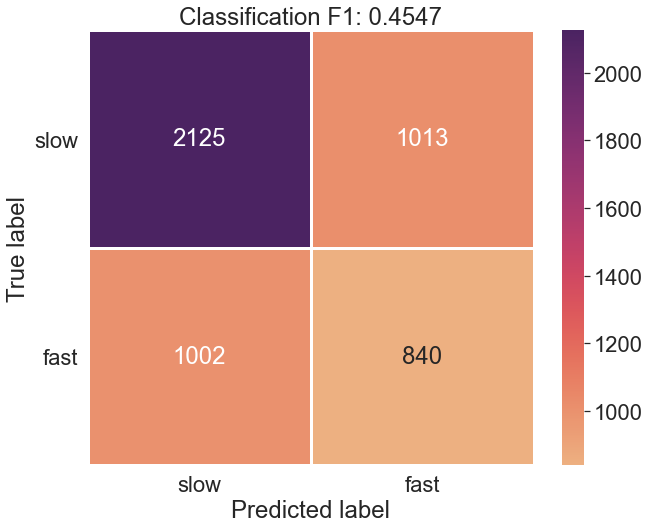

In [40]:
knn_clf_random_cv = randomized_search(knn_clf, knn_clf_params, X_train, y_train, regression=False)
best_knn_clf =  knn_clf_random_cv.best_estimator_
class_results["knn"] = score_summary(best_knn_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_knn_clf, X_test, y_test, name="class_knn")

#### Decision Trees

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__criterion': 'entropy', 'model__max_depth': 69, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 19, 'model__splitter': 'best'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.812262,0.001105,0.600251,0.004706
Precision,0.790935,0.005583,0.477561,0.006548
Recall,0.695612,0.005507,0.422431,0.023045
F1 Score,0.740178,0.001228,0.447956,0.013750
ROC AUC,0.901015,0.001579,0.599779,0.005624



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.810843,0.602811
Recall,0.693654,0.414224
Precision,0.788833,0.459085
F1 Score,0.738188,0.435502
ROC AUC,0.788843,0.563868


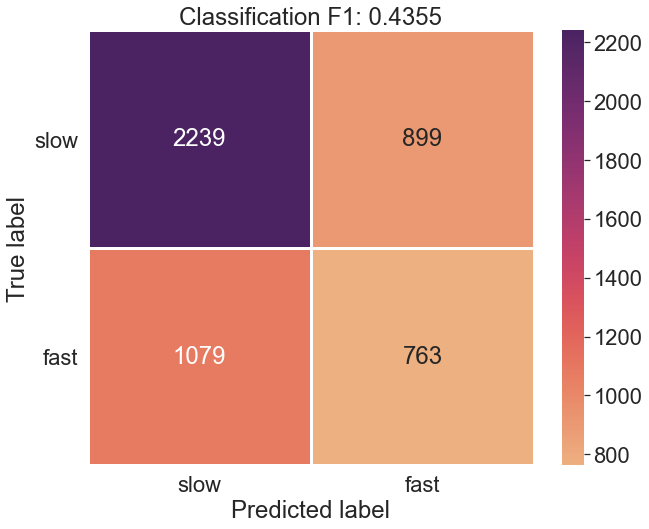

In [41]:
# perform a randomized hyperparameter search and print out CV scoring metrics
dt_clf_random_cv = randomized_search(dt_clf, dt_clf_params, X_train, y_train, regression=False)
best_dt_clf = dt_clf_random_cv.best_estimator_
# print out a score summary on full training set and test set
class_results["dt"] = score_summary(best_dt_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_dt_clf, X_test, y_test, name="_class_dt")

#### Extra Trees

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__criterion': 'entropy', 'model__max_depth': 69, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 19, 'model__splitter': 'best'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.812262,0.001105,0.600251,0.004706
Precision,0.790935,0.005583,0.477561,0.006548
Recall,0.695612,0.005507,0.422431,0.023045
F1 Score,0.740178,0.001228,0.447956,0.013750
ROC AUC,0.901015,0.001579,0.599779,0.005624



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.810843,0.602811
Recall,0.693654,0.414224
Precision,0.788833,0.459085
F1 Score,0.738188,0.435502
ROC AUC,0.788843,0.563868


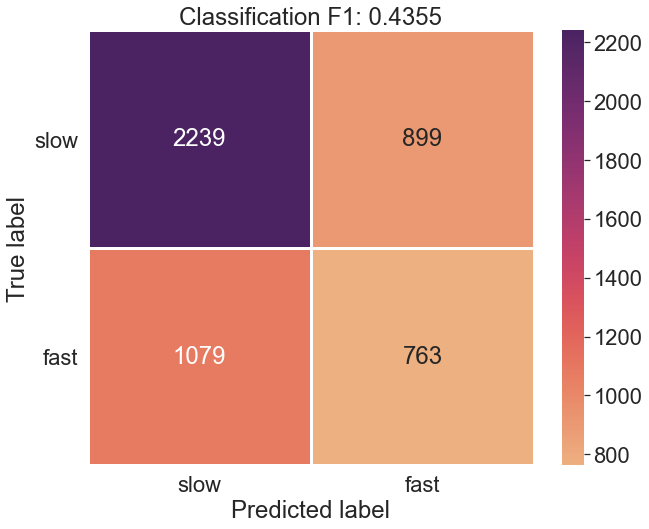

In [42]:
# perform a randomized hyperparameter search and print out CV scoring metrics
et_clf_random_cv = randomized_search(et_clf, et_clf_params, X_train, y_train, regression=False)
best_et_clf = et_clf_random_cv.best_estimator_

# print out a score summary on full training set and test set
class_results["et"] = score_summary(best_et_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_et_clf, X_test, y_test, name="class_et")

#### SVM

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'model__C': 20.273255210020587, 'model__gamma': 0.9672042018045066}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.950816,0.001553,0.597390,0.001938
Precision,0.957805,0.001518,0.472433,0.003664
Recall,0.912249,0.003013,0.406500,0.015080
F1 Score,0.934471,0.002128,0.436891,0.010228
ROC AUC,0.980824,0.001196,0.587677,0.010275



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.943825,0.589759
Recall,0.896709,0.402280
Precision,0.954413,0.440285
F1 Score,0.924662,0.420426
ROC AUC,0.934980,0.551044


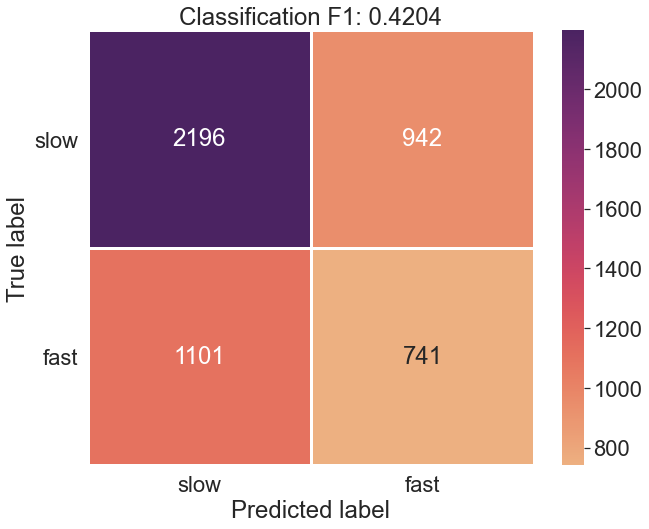

In [43]:
svm_clf_random_cv = randomized_search(svm_clf, svm_clf_params, X_train, y_train, iters=20, regression=False)
best_svm_clf = svm_clf_random_cv.best_estimator_
class_results["svm"] = score_summary(best_svm_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_svm_clf, X_test, y_test, name="class_svm")

#### Random Forests

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__bootstrap': True, 'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': 10, 'model__min_samples_leaf': 7, 'model__min_samples_split': 10, 'model__n_estimators': 254}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.673845,0.001334,0.623042,0.007889
Precision,0.556158,0.001173,0.507349,0.007660
Recall,0.750718,0.008440,0.676545,0.014345
F1 Score,0.638936,0.003242,0.579795,0.008610
ROC AUC,0.758828,0.002168,0.685183,0.006890



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.666064,0.607229
Recall,0.743144,0.672638
Precision,0.548477,0.478009
F1 Score,0.631141,0.558863
ROC AUC,0.680535,0.620736


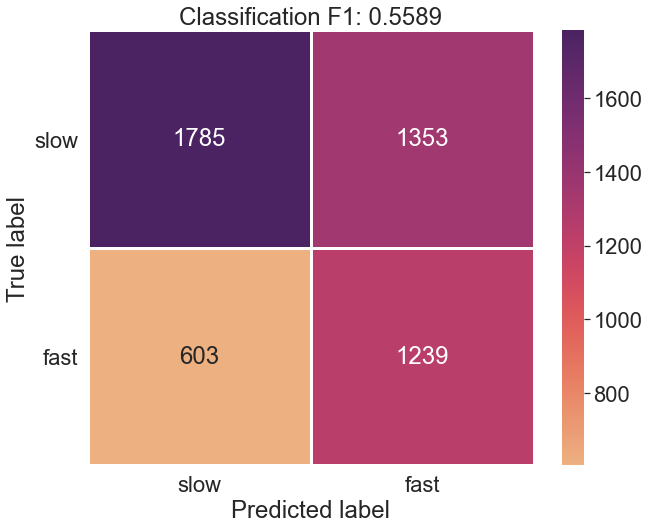

In [44]:
rf_clf_random_cv = randomized_search(rf_clf, rf_clf_params, X_train, y_train, regression=False)
best_rf_clf =  rf_clf_random_cv.best_estimator_
class_results["rf"] = score_summary(best_rf_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_rf_clf, X_test, y_test, name="class_rf")

#### Gradient Boosting

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__learning_rate': 0.395846474198672, 'model__loss': 'deviance', 'model__max_depth': 3, 'model__max_features': 'log2', 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 306, 'model__warm_start': True}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.736044,0.000868,0.649147,0.005377
Precision,0.700250,0.002879,0.556765,0.008590
Recall,0.548022,0.005484,0.427785,0.018405
F1 Score,0.614827,0.002712,0.483674,0.013921
ROC AUC,0.810410,0.001972,0.680932,0.007049



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.724699,0.647590
Recall,0.525986,0.412595
Precision,0.684801,0.530356
F1 Score,0.594978,0.464122
ROC AUC,0.687394,0.599064


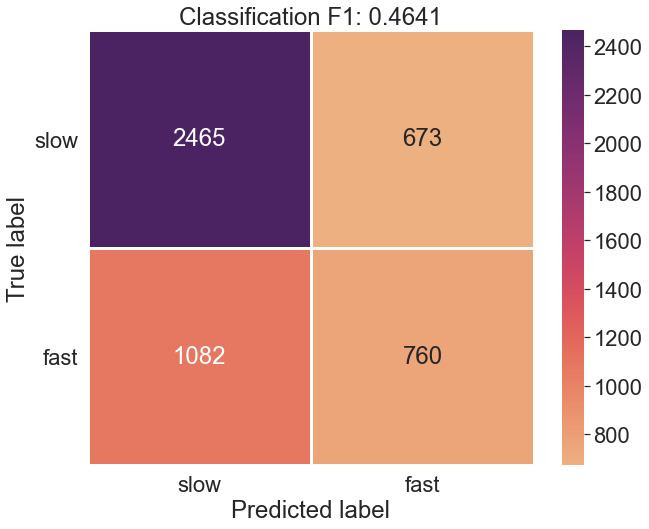

In [45]:
gb_clf_random_cv = randomized_search(gb_clf, gb_clf_params, X_train, y_train, regression=False)
best_gb_clf =  gb_clf_random_cv.best_estimator_
class_results["gb"] = score_summary(best_gb_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_gb_clf, X_test, y_test, name="class_gb")

#### Summary

In [46]:
clf_results = get_summary_df(class_results, names)
clf_results.to_csv("tables/clf_results.csv")

,Accuracy,Recall,Precision,F1 Score,ROC AUC
Dummy,0.630120,0.000000,0.000000,0.000000,0.500000
Polynomial Ridge,0.658032,0.313246,0.568473,0.403920,0.586834
KNN,0.595382,0.456026,0.453319,0.454668,0.566604
Decision Tree,0.602811,0.414224,0.459085,0.435502,0.563868
Extra Trees,0.602811,0.414224,0.459085,0.435502,0.563868
SVM,0.589759,0.402280,0.440285,0.420426,0.551044
Random Forest,0.607229,0.672638,0.478009,0.558863,0.620736
Gradient Boosting,0.647590,0.412595,0.530356,0.464122,0.599064


In [47]:
import dill as pickle

pickle.dump(best_rfr, open("model_saves/best_rfr.pkl", "wb"))
pickle.dump(best_rf_clf, open("model_saves/best_rf_clf.pkl", "wb"))
pickle.dump(best_linear, open("model_saves/best_ridge.pkl", "wb"))
pickle.dump(best_ridge_clf, open("model_saves/best_ridge_clf.pkl", "wb"))